# benchmark.ipynb

This notebook contains the text and code for the next blog post in the zero-copy model series, 
title TBD.

The first post explained how to load PyTorch models for inference extremely fast by leveraging the Plasma object store's ability to load numeric data directly from shared memory.

In this post, we talk in more concrete terms about how to use this zero-copy model loading for model serving. We put together a simple model serving system, then set up a microbenchmark that simulates a heavy-tailed traffic pattern.

In [1]:
# Initialization and import code goes in this cell.

# Imports: Python core, then third-party, then local.
# Try to keep each block in alphabetical order, or the linter may get angry.
import asyncio
import concurrent.futures
import requests
import starlette
import time
import urllib
from typing import Dict, Any, Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ray
from ray import serve
import torch
import transformers

import zerocopy


# Reduce the volume of warning messages from `transformers`
transformers.logging.set_verbosity_error()


def reboot_ray():
    if ray.is_initialized():
        ray.shutdown()

    if torch.cuda.is_available():
        return ray.init(num_gpus=1)
    else:
        return ray.init()

# Title of new blog post goes here

*Recap of previous blog post goes here.*



## Scenario

The end-to-end scenario for our benchmark involves supporting an AI chatbot.
The chatbot's conversational AI runs off of a conversation tree (**TODO:** What's the best term for this tree?). Some of the nodes of this tree invoke question answering models.

Our benchmark will cover the model serving portion of the chatbot's backend. This 
model serving layer runs question answering (QA) models on behalf of the 
chatbot's conversational AI. The chatbot's conversation tree leads to 4 very different
question answering scenarios, and each scenario has its own dedicated QA
model. Because the chatbot speaks 3 different languages, there are three versions of
each model deployed: one for each language. So the model serving layer runs a total of
12 models to cover the 4 question types and 3 languages.

> **TODO:** Cartoon block diagram of the end-to-end scenario. 
> Diagram should show a user interacting with a chatbot. The chatbot runs off of a conversation tree. 
> Some of the nodes of the conversation tree have question answering models hanging off of them.

For our question answering models, we'll use 12 copies of `deepset/roberta-base-squad2`,
the most popular question answering model on the [Huggingface model marketplace](https://huggingface.co/models).
Here's some code to load that model.

In [2]:
model_name = "deepset/roberta-base-squad2"

# Strip out this timing code for the blog version.
print("Time to load with standard method: ", end="")
%timeit -r3 transformers.pipeline("question-answering", model=model_name)
qa = transformers.pipeline("question-answering", model=model_name)

Time to load with standard method: 

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

7.89 s ± 117 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


The performance of this model isn't very sensitive to the specific question and context provided,
so we define a single set of inputs and outputs for simplicity.

In [3]:
qa_input = {
    "question": "What is 1 + 1?",
    "context": 
        """Addition (usually signified by the plus symbol +) is one of the four basic operations of 
        arithmetic, the other three being subtraction, multiplication and division. The addition of two 
        whole numbers results in the total amount or sum of those values combined. The example in the
        adjacent image shows a combination of three apples and two apples, making a total of five apples. 
        This observation is equivalent to the mathematical expression "3 + 2 = 5" (that is, "3 plus 2 
        is equal to 5").
        """
}

result = qa(qa_input)
qa_answer = result["answer"]
result

{'score': 4.278861524653621e-06, 'start': 483, 'end': 484, 'answer': '5'}

## Baseline results

Let's start with a baseline implementation of model serving for this model. This baseline implementation emulates running each QA model in a separate container. The server has 12 CPUs, so each container gets 1 CPU. We implement this baseline configuration with a pool of Ray actors.

In [4]:
serve.shutdown()
reboot_ray()
serve.start()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

(pid=9952) 2021-10-20 20:54:13,566	INFO checkpoint_path.py:15 -- Using RayInternalKVStore for controller checkpoint and recovery.
(pid=9952) 2021-10-20 20:54:13,570	INFO http_state.py:75 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:mqlxhl:SERVE_PROXY_ACTOR-node:10.168.112.7-0' on node 'node:10.168.112.7-0' listening on '127.0.0.1:8000'
2021-10-20 20:54:13,887	INFO api.py:455 -- Started Serve instance in namespace '5d3a7548-5d82-493b-a43e-c71ca55ae1d3'.


In [5]:
class QAModel:
    def __init__(self):
        self._qa = transformers.pipeline("question-answering",
                                         model=model_name)

    def __call__(self, request: starlette.requests.Request):
        # Pull model inputs from URL query parameters.
        # A production version of this code would sanitize these strings.
        model_input = {
            "question": request.query_params["question"],
            "context": request.query_params["context"]
        }
        return self._qa(model_input)


# Define endpoints
NUM_QA_MODELS = 12
deployments = [
    serve.deployment(QAModel, f"qa{model_num}")
    for model_num in range(NUM_QA_MODELS)
]

for d in deployments:
    d.deploy(_blocking=False)

# Wait a moment so log output doesn't go to the next cell's output
time.sleep(1.)

(pid=9943) INFO:     Started server process [9943]


2021-10-20 20:54:14,563	INFO api.py:243 -- Updating deployment 'qa0'. component=serve deployment=qa0
2021-10-20 20:54:14,576	INFO api.py:243 -- Updating deployment 'qa1'. component=serve deployment=qa1
2021-10-20 20:54:14,591	INFO api.py:243 -- Updating deployment 'qa2'. component=serve deployment=qa2
2021-10-20 20:54:14,609	INFO api.py:243 -- Updating deployment 'qa3'. component=serve deployment=qa3
2021-10-20 20:54:14,629	INFO api.py:243 -- Updating deployment 'qa4'. component=serve deployment=qa4
(pid=9952) 2021-10-20 20:54:14,633	INFO backend_state.py:896 -- Adding 1 replicas to deployment 'qa0'. component=serve deployment=qa0
(pid=9952) 2021-10-20 20:54:14,645	INFO backend_state.py:896 -- Adding 1 replicas to deployment 'qa1'. component=serve deployment=qa1
(pid=9952) 2021-10-20 20:54:14,659	INFO backend_state.py:896 -- Adding 1 replicas to deployment 'qa2'. component=serve deployment=qa2
(pid=9952) 2021-10-20 20:54:14,671	INFO backend_state.py:896 -- Adding 1 replicas to deployme

In [6]:
# Try out the deployment.
# This web service call blocks until the asychronous deployment has completed.
params = urllib.parse.urlencode(qa_input)
requests.get(f"http://127.0.0.1:8000/qa0?{params}").json()

{'score': 4.278861524653621e-06, 'start': 483, 'end': 484, 'answer': '5'}

Let's wrap this model web service in a callback function that calls the model, retrieves the result, and
returns elapsed time.

In [7]:
def call_model(model_num: int, question: str, context: str, expected_answer: str) -> float:
    """
    Callack function that calls the model deployment, retrieves and 
    validates the result, and returns elapsed time.

    :param model_num: Index of the model to call
    :param question: The `question` argument to pass to the QA model
    :param context: The `context` argument to pass to the QA model
    :param expected_answer: The answer that the model should return

    :returns: Tuple of start and end times of the web service call
    """
    # For now, use the same input every time
    params = urllib.parse.urlencode({"question": question, "context": context})

    start_time = time.time()
    result = requests.get(f"http://127.0.0.1:8000/qa{model_num}?{params}").json()
    end_time = time.time()

    # Do some basic validation
    if result["answer"] != expected_answer:
        raise ValueError(f"Unexpected result: {result}")

    return (start_time, end_time)


times = call_model(0, qa_input["question"], qa_input["context"], qa_answer)
f"{times[1] - times[0]:1.3f} seconds elapsed"

'0.575 seconds elapsed'

Now we can define a simple benchmark.

In [8]:
def gen_model_ids(lambda_: float, num_models: int, num_points: int) -> np.ndarray:
    """
    Draw model IDs at random from a truncated Poisson distribution.

    :param lambda_: Primary parameter of the distribution, which also happens to 
     be the mean value of the (untruncated) distribution.
    :num_models: Number of models. This function will truncate the Poisson 
     distribution such that only values < num_models will be returned.
    :param num_points: Number of random model IDs to return.

    :returns: Randomly generated model IDs for a series of requests, as a
     1-dimensional array.
    """
    # Draw numbers from a truncated Poisson distribution.
    # Start with a non-truncated distribution, then resample for
    # any values that went over the limit. 
    rng = np.random.default_rng()
    result = rng.poisson(lambda_, size=num_points)
    while np.any(result >= num_models):
        new_values = rng.poisson(lambda_, size=np.sum(result >= num_models))
        result[result >= num_models] = new_values
    return result


def run_benchmark(model_callback: Callable, requests_per_sec: float, num_sec: int,
                  lambda_: float = 0.3) -> pd.DataFrame:
    """
    A simple benchmark in Python.

    Sends a constant-rate stream of requests to multiple models, with the division
    of traffic among models following a truncated Poisson distribution.

    Because some notebook servers (i.e. VSCode) don't play well with 
    asyncio, we use threads to manage concurrent requests.

    :param model_callback: Thread-safe callback function that makes a 
     single request and returns elapsed time. Should have the signature
     `f(model_num: int, question: str, context: str, expected_answer: str)`
    :param request_per_sec: Constant request rate to use
    :param num_sec: Seconds of traffic to generate at the requested rate.
     The actual session will extend past this window until all open requests have
     finished.
    :param lambda_: Primary parameter of the truncated Poisson distribution
     used to split requests among models. Approximately equal to the mean of
     the distribution. The default value of 0.3 sends 70% of traffic to model 0.

    :returns: DataFrame of benchmark results at per-request granularity
    """
    # Convert benchmark paramters into a more useable internal form
    sec_per_request = 1.0 / requests_per_sec
    num_requests = int(num_sec * requests_per_sec)

    # Preallocate the trace as a set of lists.
    benchmark_start_time = time.time()
    desired_start_times = [benchmark_start_time + (sec_per_request * i)
                           for i in range(num_requests)]
    model_nums = gen_model_ids(lambda_, NUM_QA_MODELS, num_requests)
    actual_start_times = [None] * num_requests
    end_times = [None] * num_requests

    # Unbounded thread pool
    thread_pool = concurrent.futures.ThreadPoolExecutor(1000)

    # Map from request object to request number
    active_requests = {}  # type: Dict[concurrent.futures.Future, int]

    # Main event loop: Spawn background requests, get their responses.
    request_num = 0
    while request_num < num_requests or len(active_requests) > 0:
        sec_to_next = (
            1.0 if request_num >= num_requests
            else desired_start_times[request_num] - time.time()
        )
        if sec_to_next <= 0:
            # Time to send the next request
            model_num = model_nums[request_num]
            future = thread_pool.submit(
                model_callback, model_num,
                qa_input["question"], qa_input["context"], qa_answer)
            active_requests[future] = request_num
            request_num += 1
        else:
            # Block until it's time to send the next request or a previous
            # request is done.
            ready_set, _ = concurrent.futures.wait(
                list(active_requests.keys()), 
                timeout=sec_to_next)

            # Record timings from any open requests that have completed.
            for future in ready_set:
                request_id = active_requests.pop(future)
                start_time, end_time = future.result()
                actual_start_times[request_id] = start_time
                end_times[request_id] = end_time

    # Collate results as a DataFrame
    result = pd.DataFrame({
        "request_id": range(num_requests),
        "model_num": model_nums, 
        "desired_start": desired_start_times, 
        "actual_start": actual_start_times, 
        "end": end_times
    })

    # Make all times relative to start of the trace
    for key in ("desired_start", "actual_start", "end"):
        result[key] -= benchmark_start_time
    result["latency"] = result["end"] - result["actual_start"]

    return result


# Quick test run
run_benchmark(call_model, 12, 5)

,request_id,model_num,desired_start,actual_start,end,latency
0,0,0,0.000000,0.001167,0.595420,0.594253
1,1,1,0.083333,0.083947,0.719541,0.635595
2,2,0,0.166667,0.167284,3.778072,3.610788
3,3,0,0.250000,0.250631,3.779140,3.528509
4,4,0,0.333333,0.334094,3.780045,3.445951
5,5,0,0.416667,0.417304,3.780638,3.363334
6,6,0,0.500000,0.500666,3.781295,3.280629
7,7,1,0.583333,0.584048,1.659619,1.075570
8,8,0,0.666667,0.667175,9.951593,9.284418
9,9,0,0.750000,0.750496,9.952491,9.201994


Let's run the benchmark with our baseline model deployment.

In [9]:
# Run the benchmark at multiple different request rates
REQUEST_RATES = (2, 3, 4, 5, 6, 8, 10, 12, 14)
RUNNING_TIME_SEC = 20
to_concat = []
for request_rate in REQUEST_RATES:
    print(f"Running at {request_rate} requests/sec.")
    times = run_benchmark(call_model, request_rate, RUNNING_TIME_SEC)
    times.insert(0, "request_rate", request_rate)
    to_concat.append(times)

results = pd.concat(to_concat)

Running at 2 requests/sec.
Running at 3 requests/sec.
Running at 4 requests/sec.
Running at 5 requests/sec.
Running at 6 requests/sec.
Running at 8 requests/sec.
Running at 10 requests/sec.
Running at 12 requests/sec.
Running at 14 requests/sec.


In [10]:
results[results["request_rate"] == 10]

,request_rate,request_id,model_num,desired_start,actual_start,end,latency
0,10,0,0,0.0,0.000687,0.598512,0.597824
1,10,1,1,0.1,0.100573,0.677595,0.577022
2,10,2,0,0.2,0.200560,2.982452,2.781892
3,10,3,0,0.3,0.300656,2.982779,2.682123
4,10,4,0,0.4,0.400585,2.981026,2.580440
...,...,...,...,...,...,...,...
195,10,195,0,19.5,19.501365,88.028450,68.527084
196,10,196,0,19.6,19.601294,88.030012,68.428718
197,10,197,0,19.7,19.701446,88.027074,68.325628
198,10,198,0,19.8,19.801301,88.020692,68.219391


In [11]:
agg_results = results.groupby("request_rate").aggregate({"latency": ["mean", "median", "max"]})
agg_results

latency                       
                   mean     median         max
request_rate                                  
2              0.823223   0.711840    1.710964
3              3.632496   3.559592    8.935509
4              5.569451   4.460295   15.768425
5             10.835998  10.222980   26.460494
6             17.924395  23.239724   36.017753
8             28.635715  23.774603   56.035316
10            34.863745  40.067194   72.095605
12            45.275019  54.754834   94.860349
14            53.107382  53.258820  115.447977

Text(0, 0.5, 'Average Latency (sec)')

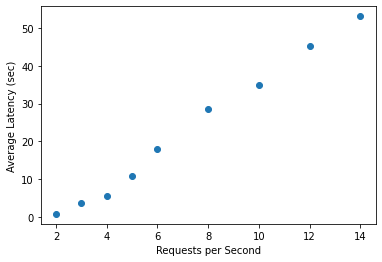

In [12]:
plt.scatter(agg_results.index, agg_results["latency", "mean"])
plt.xlabel("Requests per Second")
plt.ylabel("Average Latency (sec)")

## Using zero-copy model loading

Now let's redo this baseline using zero-copy model loading.
First we'll need to convert the model into a format that can be loaded without copying
data. The model is actually a pipeline of multiple operations, but the RoBERTa model
at its center is orders of magnitude larger and more CPU-intensive than everything else, so we'll only apply zero-copy loading to that part.



In [13]:
serve.shutdown()
reboot_ray()
serve.start()

(pid=9952) 2021-10-20 21:04:25,851	INFO backend_state.py:914 -- Removing 1 replicas from deployment 'qa0'. component=serve deployment=qa0
(pid=9952) 2021-10-20 21:04:25,856	INFO backend_state.py:914 -- Removing 1 replicas from deployment 'qa1'. component=serve deployment=qa1
(pid=9952) 2021-10-20 21:04:25,861	INFO backend_state.py:914 -- Removing 1 replicas from deployment 'qa2'. component=serve deployment=qa2
(pid=9952) 2021-10-20 21:04:25,872	INFO backend_state.py:914 -- Removing 1 replicas from deployment 'qa3'. component=serve deployment=qa3
(pid=9952) 2021-10-20 21:04:25,878	INFO backend_state.py:914 -- Removing 1 replicas from deployment 'qa4'. component=serve deployment=qa4
(pid=9952) 2021-10-20 21:04:25,882	INFO backend_state.py:914 -- Removing 1 replicas from deployment 'qa5'. component=serve deployment=qa5
(pid=9952) 2021-10-20 21:04:25,887	INFO backend_state.py:914 -- Removing 1 replicas from deployment 'qa6'. component=serve deployment=qa6
(pid=9952) 2021-10-20 21:04:25,892

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

(pid=12520) 2021-10-20 21:04:29,358	INFO checkpoint_path.py:15 -- Using RayInternalKVStore for controller checkpoint and recovery.
(pid=12520) 2021-10-20 21:04:29,362	INFO http_state.py:75 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:tRFmJV:SERVE_PROXY_ACTOR-node:10.168.112.7-0' on node 'node:10.168.112.7-0' listening on '127.0.0.1:8000'
2021-10-20 21:04:29,712	INFO api.py:455 -- Started Serve instance in namespace '0dae731c-037d-42fa-bc56-a7050297e30b'.


## Introducing `zerocopy`

We've created a Python package, `zerocopy`, with the model rewrite code from our previous post (TODO: Publish the package to PyPI).

To use that package, you'll need to install it with `pip`, then import it into your script.

```python
import zerocopy
```


In [14]:
# TODO: Move this code to the `zerocopy` library.
@ray.remote
def call_model_zero_copy(model_ref: ray.ObjectRef, args, kwargs) -> Any:
    """
    Ray task that uses zero-copy model loading to reconstitute a model
    from Plasma, then invokes the model's ``__call__()`` method.

    :param model_ref: Object reference to a tuple of model skeleton
     and model weights, as returned by :func:`extract_tensors`
    :param args: Ordered arguments to pass to the model's :func:`__call__`
     method
    :param kwargs: Keyword arguments to pass to the model's :func:`__call__`
     method

    :returns: Return value from the model's :func:`__call__` method
    """
    # Suppress PyTorch warnings about immutable tensors
    import warnings
    warnings.filterwarnings("ignore")

    model_skeleton, model_weights = model_ref
    zerocopy.replace_tensors(model_skeleton, model_weights)
    with torch.no_grad():
        return model_skeleton(*args, **kwargs)

(pid=12511) INFO:     Started server process [12511]


In [15]:
# Call the model directly
inputs = qa.tokenizer(qa_input["question"], qa_input["context"], return_tensors="pt")
qa.model(**inputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 3.7534, -8.7741, -9.1023, -6.6326, -8.7627, -8.6893, -9.7706, -9.6873,
         -9.6512, -4.1902, -7.6596, -8.5491, -7.9478, -7.5671, -9.0784, -8.2897,
         -7.5410, -5.9760, -7.2943, -6.4249, -9.3297, -8.9922, -7.9955, -8.9485,
         -8.7506, -6.1065, -8.2273, -8.4471, -8.9334, -2.9227, -2.8201, -4.6316,
         -5.5576, -5.7634, -5.8722, -5.9716, -6.2091, -6.0458, -5.3727, -9.8484,
         -8.4069, -7.6116, -5.1946, -8.7245, -4.3298, -8.3712, -8.5934, -4.6927,
         -8.6297, -5.4113, -8.5218, -6.5587, -6.0347, -9.0888, -3.9168, -3.7715,
         -4.0178, -5.5528, -6.2156, -6.1800, -6.1387, -6.2229, -6.4473, -6.3201,
         -6.2259, -8.2617, -8.0752, -8.5442, -7.0337, -5.3173, -7.1967, -8.6134,
         -5.5957, -9.0524, -8.1817, -7.5553, -7.3491, -8.5218, -7.5425, -7.8877,
         -8.3360, -8.1147, -5.0947, -5.1871, -6.5926, -6.7610, -6.7855, -6.8672,
         -6.9245, -6.7498, -7.7118, -8.6336, -8.0724, -7

In [16]:
# Call the model via `call_model`. Results should be the same as the previous cell.
model_ref = ray.put(zerocopy.extract_tensors(qa.model))
ray.get(call_model_zero_copy.remote(model_ref, [], inputs))

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 3.7534, -8.7741, -9.1023, -6.6326, -8.7627, -8.6893, -9.7706, -9.6873,
         -9.6512, -4.1902, -7.6596, -8.5491, -7.9478, -7.5671, -9.0784, -8.2897,
         -7.5410, -5.9760, -7.2943, -6.4249, -9.3297, -8.9922, -7.9955, -8.9485,
         -8.7506, -6.1065, -8.2273, -8.4471, -8.9334, -2.9227, -2.8201, -4.6316,
         -5.5576, -5.7634, -5.8722, -5.9716, -6.2091, -6.0458, -5.3727, -9.8484,
         -8.4069, -7.6116, -5.1946, -8.7245, -4.3298, -8.3712, -8.5934, -4.6927,
         -8.6297, -5.4113, -8.5218, -6.5587, -6.0347, -9.0888, -3.9168, -3.7715,
         -4.0178, -5.5528, -6.2156, -6.1800, -6.1387, -6.2229, -6.4473, -6.3201,
         -6.2259, -8.2617, -8.0752, -8.5442, -7.0337, -5.3173, -7.1967, -8.6134,
         -5.5957, -9.0524, -8.1817, -7.5553, -7.3491, -8.5218, -7.5425, -7.8877,
         -8.3360, -8.1147, -5.0947, -5.1871, -6.5926, -6.7610, -6.7855, -6.8672,
         -6.9245, -6.7498, -7.7118, -8.6336, -8.0724, -7

The time to invoke the model once via `call_model_zero_copy()` is almost the same as running the model locally.

In [17]:
# Compare timings
print("       Time to run locally: ", end="")
%timeit qa.model(**inputs)
print("Time to run with zero-copy: ", end="")
%timeit ray.get(call_model_zero_copy.remote(model_ref, [], inputs))

       Time to run locally: 527 ms ± 4.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time to run with zero-copy: 600 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If we run inference multiple times, `call_model_zero_copy()` can send those inference requests to separate Ray tasks that run in parallel.

In [18]:
def run_local(num_repeats: int):
    for _ in range(num_repeats):
        qa.model(**inputs)


def run_zero_copy(num_repeats: int):
    futures = [call_model_zero_copy.remote(model_ref, [], inputs) for _ in range(num_repeats)]
    ray.get(futures)


NUM_REPEATS = 100
print(f"       Time to run {NUM_REPEATS} times locally: ", end="")
%timeit -r 3 run_local(NUM_REPEATS)
print(f"Time to run {NUM_REPEATS} times with zero-copy: ", end="")
%timeit -r 3 run_zero_copy(NUM_REPEATS)

       Time to run 100 times locally: 51.5 s ± 80.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Time to run 100 times with zero-copy: 

(pid=13783) [2021-10-20 21:08:13,906 C 13783 13846] core_worker.cc:210:  Check failed: core_worker_process The core worker process is not initialized yet or already shutdown.
(pid=13783) *** StackTrace Information ***
(pid=13783)     ray::SpdLogMessage::Flush()
(pid=13783)     ray::RayLog::~RayLog()
(pid=13783)     ray::core::CoreWorkerProcess::EnsureInitialized()
(pid=13783)     ray::core::CoreWorkerProcess::GetCoreWorker()
(pid=13783)     __pyx_pw_3ray_7_raylet_10CoreWorker_23get_worker_id()
(pid=13783)     method_vectorcall_NOARGS
(pid=13783) 


7.3 s ± 41.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Now let's define a Ray Serve endpoint that runs the model preprocessing code locally and farms out model inference 
to Ray tasks that use zero-copy model loading.

In [19]:
class ZeroCopyQAModel:
    def __init__(self):
        # TODO: Move this rewrite to the `zerocopy` library.
        # Load the entire pipeline, then copy the model portion to Plasma.
        self._qa = transformers.pipeline("question-answering", model=model_name)
        model_ref = ray.put(zerocopy.extract_tensors(self._qa.model))

        # Replace the pipeline's model with a callback that farms out work to
        # Ray tasks.
        class _ModelCallback:
            def __call__(self, *args, **kwargs):
                return ray.get(call_model_zero_copy.remote(model_ref, args, kwargs))
        self._qa.model = _ModelCallback()

        # Use a threadpool because the model is called from pre/postprocessing code
        # that is not asyncio-aware
        self._threadpool = concurrent.futures.ThreadPoolExecutor()

    async def __call__(self, request: starlette.requests.Request):
        # Pull model inputs from URL query parameters.
        # A production version of this code would sanitize these strings.
        model_input = {
            "question": request.query_params["question"],
            "context": request.query_params["context"]
        }
        result = await asyncio.get_running_loop().run_in_executor(
            self._threadpool, lambda: self._qa(model_input))
        return result

    def __del__(self):  # Ray Serve needs this callback
        pass


# Define endpoints
NUM_QA_MODELS = 12
deployments = [
    serve.deployment(ZeroCopyQAModel, f"qa{model_num}",
                     ray_actor_options={"num_cpus": 0.1})
    for model_num in range(NUM_QA_MODELS)
]

for d in deployments:
    d.deploy(_blocking=False)

# Wait a moment so log output doesn't go to the next cell's output
time.sleep(1.)

2021-10-20 21:08:42,105	INFO api.py:243 -- Updating deployment 'qa0'. component=serve deployment=qa0
2021-10-20 21:08:42,124	INFO api.py:243 -- Updating deployment 'qa1'. component=serve deployment=qa1
2021-10-20 21:08:42,144	INFO api.py:243 -- Updating deployment 'qa2'. component=serve deployment=qa2
(pid=12520) 2021-10-20 21:08:42,157	INFO backend_state.py:896 -- Adding 1 replicas to deployment 'qa0'. component=serve deployment=qa0
(pid=12520) 2021-10-20 21:08:42,170	INFO backend_state.py:896 -- Adding 1 replicas to deployment 'qa1'. component=serve deployment=qa12021-10-20 21:08:42,249	INFO api.py:243 -- Updating deployment 'qa3'. component=serve deployment=qa3

(pid=12520) 2021-10-20 21:08:42,184	INFO backend_state.py:896 -- Adding 1 replicas to deployment 'qa2'. component=serve deployment=qa2
2021-10-20 21:08:42,420	INFO api.py:243 -- Updating deployment 'qa4'. component=serve deployment=qa4
(pid=12520) 2021-10-20 21:08:42,360	INFO backend_state.py:896 -- Adding 1 replicas to depl

(qa9 pid=12519) 


In [20]:
# Try out the new deployment.
# This web service call blocks until the asychronous deployment has completed.
params = urllib.parse.urlencode(qa_input)
requests.get(f"http://127.0.0.1:8000/qa0?{params}").json()

{'score': 4.278861524653621e-06, 'start': 483, 'end': 484, 'answer': '5'}

We've deployed these models to the same URLs, so the benchmark code from before should work without
any changes.

In [21]:
# Quick test run
run_benchmark(call_model, 5, 10)

(call_model_zero_copy pid=19553) 


,request_id,model_num,desired_start,actual_start,end,latency
0,0,0,0.0,0.002588,0.651200,0.648612
1,1,0,0.2,0.200472,0.910769,0.710297
2,2,0,0.4,0.406986,2.784124,2.377137
3,3,1,0.6,0.613067,6.290897,5.677830
4,4,1,0.8,0.801439,8.471517,7.670078
5,5,0,1.0,1.000481,1.769227,0.768746
6,6,0,1.2,1.200652,1.924669,0.724016
7,7,0,1.4,1.400715,4.160921,2.760206
8,8,0,1.6,1.600872,2.759574,1.158702
9,9,0,1.8,1.800555,2.846194,1.045639


In [22]:
# Run the benchmark at multiple different request rates
to_concat = []
for request_rate in REQUEST_RATES:
    print(f"Running at {request_rate} requests/sec.")
    times = run_benchmark(call_model, request_rate, RUNNING_TIME_SEC)
    times.insert(0, "request_rate", request_rate)
    to_concat.append(times)

results_zerocopy = pd.concat(to_concat)

Running at 2 requests/sec.
Running at 3 requests/sec.
Running at 4 requests/sec.
Running at 5 requests/sec.
Running at 6 requests/sec.
Running at 8 requests/sec.
Running at 10 requests/sec.
Running at 12 requests/sec.
(call_model_zero_copy pid=21680) 
Running at 14 requests/sec.
(call_model_zero_copy pid=21859) 


In [23]:
agg_results_zerocopy = results_zerocopy.groupby("request_rate").aggregate({"latency": ["mean", "median", "max"]})
agg_results_zerocopy

latency                    
                  mean    median       max
request_rate                              
2             0.620998  0.627903  0.700807
3             0.614318  0.614274  0.647115
4             0.761776  0.609324  2.563932
5             0.910136  0.660313  2.830024
6             1.156761  0.880779  3.985181
8             1.188385  0.953722  3.547060
10            1.392834  1.153224  4.321831
12            1.575299  1.462212  4.366010
14            2.673118  2.923379  4.338705

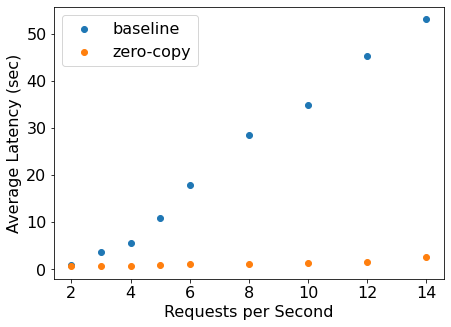

In [24]:
# Plot the two sets of results against each other.
plt.rcParams.update({"font.size": 16})
plt.figure(figsize=(7, 5))
plt.scatter(agg_results.index, agg_results["latency", "mean"],
            label="baseline")
plt.scatter(agg_results_zerocopy.index, agg_results_zerocopy["latency", "mean"],
            label="zero-copy")
plt.xlabel("Requests per Second")
plt.ylabel("Average Latency (sec)")
plt.legend()

In [25]:
# Old code defined an actor

# class ModelCallback:
#     def __init__(self, model_ref: ray.ObjectRef):
#         self._model_ref = model_ref

#     def __call__(self, *args: Any, **kwargs: Any) -> Any:
#         return ray.get(call_model.remote(self._model_ref, args, kwargs))

# @ray.remote
# class QAModelZeroCopyActor:
#     def __init__(self):
#         self._qa = transformers.pipeline("question-answering", model=model_name)
#         self._model_ref = ray.put(zerocopy.extract_tensors(self._qa.model))
#         self._qa.model = ModelCallback(self._model_ref)

#     def run_inference(self, input_: Dict[str, str]) -> Dict[str, Any]:
#         return self._qa(input_)

# zero_copy_actors = [QAModelZeroCopyActor.options(max_concurrency=8).remote() 
#                     for _ in range(NUM_QA_MODELS)]
# ray.get(zero_copy_actors[0].run_inference.remote(qa_input))